<a href="https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW06/HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - 生成对抗网络 (Generative Adversarial Network)**

做一个人脸识别的对抗生成网络

### 配置环境


In [5]:
#超参数
# # You may replace the workspace directory if you want.
workspace_dir = '/Users/allen/Documents/allen/source/machineLearning-DeepLearning/HW06'
batch_size = 64
z_dim = 100


### 下载数据集

如果下载失败使用这个链接(https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

### 解压文件夹
解压文件后的目录结构

```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [6]:
# !unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## 导入后期需要的包

In [7]:
import os
import glob

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image



## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [8]:
class MyDataSet(Dataset):
    def __init__(self, root):
        names = glob.glob(os.path.join(root,"*"))
        print("---------------names---------------")
        print(len(names))
        # names = names[:6400*2]
        self.names = names

        self.formatImage = transforms.Compose([
            transforms.ToPILImage(),
            # 输入图片128X128、 模型是64X64的输出、所以这里先变成64X64
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])
    def __getitem__(self, index):
        file = self.names[index]
        # print("-------file-------")
        # print(file)
        img = torchvision.io.read_image(file)
        # img = Image.open(file)
        return self.formatImage(img)

    def __len__(self):
        return len(self.names)

formatImage = transforms.Compose([
            # transforms.ToPILImage(),
            # 输入图片128X128、 模型是64X64的输出、所以这里先变成64X64
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])
        

### 展示前16张图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------names---------------
71314


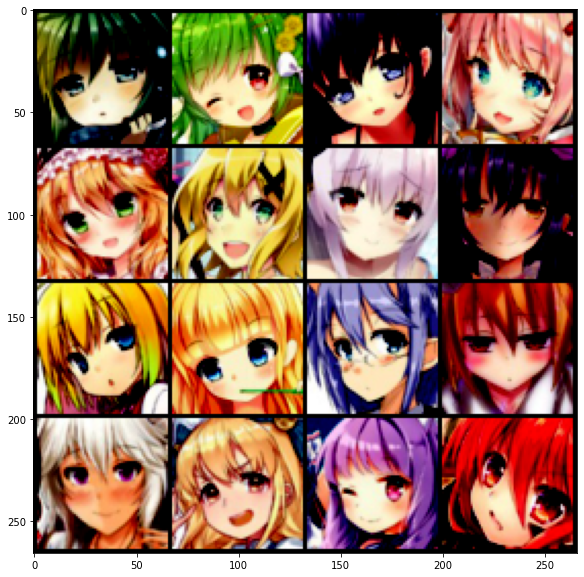

In [9]:
dataset = MyDataSet(os.path.join(workspace_dir, 'faces'))
images = [dataset[i] for i in range(16)]

device =  'cuda' if torch.cuda.is_available() else 'cpu'
# dataset = DatasetFolder(workspace_dir, loader= lambda x: Image.open(x), extensions='jpg', transform=formatImage)
# train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)

grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### 生成模型
使用的是DCGAN

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class Generator(nn.Module):
    def __init__(self, in_dim,out_dim=64):
        """
        Input shape: (N, in_dim)
        Output shape: (N, 3, 64, 64)
        """
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
          return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride =2, padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, out_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(out_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(out_dim * 8, out_dim * 4),
            dconv_bn_relu(out_dim * 4, out_dim * 2),
            dconv_bn_relu(out_dim * 2, out_dim),
            nn.ConvTranspose2d(in_channels=out_dim, out_channels =3, kernel_size=5, stride =2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        y = self.l1(x)
        # 把数据变成指定纬度
        # import torch
        # a = torch.arange(0,20)	#此时a的shape是(1,20)
        # a.view(4,5).shape		    #输出为(4,5)
        # a.view(-1,5).shape		#输出为(4,5)
        # a.view(4,-1).shape		#输出为(4,5)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


### 判别模型
DCGAN

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_dim,out_dim=64):
        super(Discriminator,self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
          return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=5, stride =2, padding=2,),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
        """  WGAN需要一处最后一层的Sigmoid """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, out_dim,  kernel_size=5, stride =2, padding=2,), 
            nn.LeakyReLU(0.2),
            dconv_bn_relu(out_dim, out_dim * 2),
            dconv_bn_relu(out_dim * 2, out_dim * 4),
            dconv_bn_relu(out_dim * 4, out_dim * 8),
            nn.Conv2d(out_dim * 8, 1, 4),
            ## 比WGAN多了一个激活函数
            nn.Sigmoid(), 
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        # 把数据变成一维的
        y = y.view(-1)
        return y

### 训练预设
- 初始化数据
    - 超参数
    - 模型
    - 优化器
    - 数据加载器

In [12]:
# 输出预测数据用的
z_sample = torch.randn(100, z_dim).to(device)
lr = 1e-4

"""  WGAN中, epoch=50, n_critic=5, clip_value=0.01 """
n_epoch = 1 # 50
n_critic = 1 # 5
# clip_value = 0.01
log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)


#加载模型
G = Generator(z_dim).to(device)
# print("--------------------Generator-----------------")
# print(G)
D = Discriminator(3).to(device)
# print("--------------------Discriminator-----------------")
# print(D)
G.train()
D.train()

# 损失函数
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()


#优化器 WGAN中使用RMSprop
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

# 数据加载器
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)



### 开始训练
 定期存储一些图片来监控生成器的当前性能，并定期记录检查点。

---------开始训练--------------
Epoch:1 | Loss_D:0.6153,Loss_G:2.9306,Step:1
Epoch:2 | Loss_D:1.2872,Loss_G:2.8406,Step:2
Epoch:3 | Loss_D:0.9751,Loss_G:4.1931,Step:3
Epoch:4 | Loss_D:0.557,Loss_G:5.5377,Step:4
Epoch:5 | Loss_D:0.3237,Loss_G:5.4426,Step:5
Epoch:6 | Loss_D:0.3581,Loss_G:5.8607,Step:6
Epoch:7 | Loss_D:0.2991,Loss_G:6.4841,Step:7
Epoch:8 | Loss_D:0.2596,Loss_G:6.8196,Step:8
Epoch:9 | Loss_D:0.2577,Loss_G:7.6822,Step:9
Epoch:10 | Loss_D:0.2342,Loss_G:7.091,Step:10
Epoch:11 | Loss_D:0.2633,Loss_G:8.4969,Step:11
Epoch:12 | Loss_D:0.1277,Loss_G:7.678,Step:12
Epoch:13 | Loss_D:0.2053,Loss_G:7.4161,Step:13
Epoch:14 | Loss_D:0.1613,Loss_G:9.0134,Step:14
Epoch:15 | Loss_D:0.0545,Loss_G:7.7319,Step:15
Epoch:16 | Loss_D:0.2205,Loss_G:9.0894,Step:16
Epoch:17 | Loss_D:0.0885,Loss_G:8.3262,Step:17
Epoch:18 | Loss_D:0.1853,Loss_G:9.0696,Step:18
Epoch:19 | Loss_D:0.0886,Loss_G:8.9989,Step:19
Epoch:20 | Loss_D:0.1328,Loss_G:10.4766,Step:20
Epoch:21 | Loss_D:0.1563,Loss_G:8.3762,Step:21
Epoch

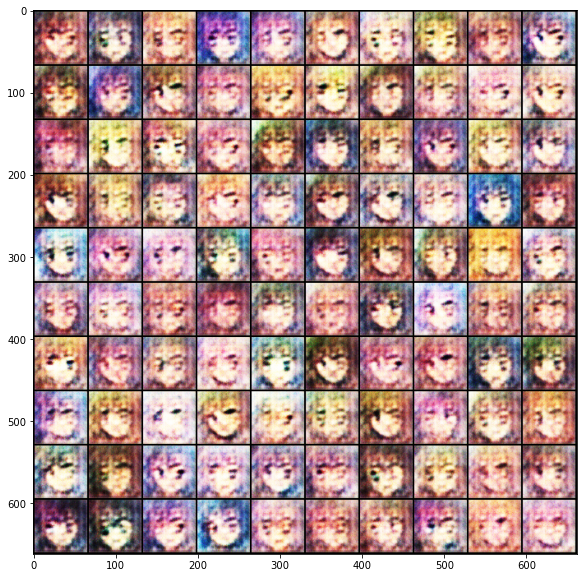

In [13]:
steps = 0
for n,epoch in enumerate(range(n_epoch)):
    print("---------开始训练--------------")
    for n, imgs in enumerate(dataloader):
        # i, imgs = batch
        bs = imgs.size(0)

        # ============================================
        #  Train D 判别器
        # ============================================
        # torch.randn产生(0,1)正态分布的数据
        random_img = torch.randn(bs,z_dim).to(device)
        # 生成器生成一个图片
        g_img = G(random_img)
        # if steps % 50 ==0:
        #     save_image(g_img,"step_%d" % steps)
        #     grid_img = torchvision.utils.make_grid(g_img.detach().numpy(), nrow=2)
        #     plt.figure(figsize=(10,10))
        #     plt.imshow(g_img)
        #     plt.show()
        G.train()
        # 判别器进行判别
        r_logit = D(imgs.detach())
        g_logit = D(g_img.detach())

        # 标签
        r_label = torch.ones(bs).to(device)
        g_label = torch.zeros(bs).to(device)

        #计算判别器的损失值
        r_loss = criterion(r_logit,r_label)
        g_loss = criterion(g_logit,g_label)
        loss_D = (r_loss + g_loss) / 2

        # 向前传播
        D.zero_grad()
        loss_D.backward()
        #更新优化器
        opt_D.step()

        # ============================================
        #  训练生成器 G
        # ============================================
        #  训练判别器n_critic次后、在训练生成器
        if steps % n_critic == 0:
            rand_img = torch.randn(bs,z_dim).to(device)
            f_img = G(rand_img)
            f_logit = D(f_img)

            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            #向前传播
            G.zero_grad()
            loss_G.backward()
            opt_G.step()
        steps +=1
        print("Epoch:{} | Loss_D:{},Loss_G:{},Step:{}".format(n+1,round(loss_D.item(), 4),round(loss_G.item(), 4),steps))
     
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, 'Epoch_%d.jpg' % (epoch+1))
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(' | Save some samples to {%s}.'% filename)

    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (n+1) % 5 == 0 or n == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))

### 加载模型
生成一些图片看看

In [51]:
import torch
import numpy as np
import torchvision.utils as vutils

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.to(device)

# Generate 1000 images and make a grid to save them.
n_output = 1
z_sample = torch.randn(n_output, z_dim).to(device)
imgs_sample = (G(z_sample).data + 1) / 2.0
imgs_sample = imgs_sample.squeeze(0)
print("--------------imgs_sample-----------------")
print(imgs_sample.size())
imgs_sample = G(z_sample)
imgs_sample = vutils.make_grid(imgs_sample, padding=2, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(imgs_sample,(1,2,0)))
plt.show()


log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.png')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# # Show 32 of the images.
# grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
# plt.figure(figsize=(10,10))
# plt.imshow(grid_img.permute(1, 2, 0))
# plt.show()

--------------imgs_sample-----------------
torch.Size([3, 64, 64])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 720x720 with 0 Axes>

In [ ]:
# x = torch.randn(1, 3, 64, 64)

# with torch.no_grad():
#     torch.onnx.export(
#         G,
#         x,
#         "hw06-GAN.onnx",
#         opset_version=11,
#         input_names=['input'],
#         output_names=['output'])


### 保存生成图片

In [ ]:
# # Save the generated images.
# os.makedirs('output', exist_ok=True)
# for i in range(1000):
#     torchvision.utils.save_image(imgs_sample[i], 'output_%d.jpg'% (i+1))
  
# # Compress the images.
# %cd output
# !tar -zcf ../images.tgz *.jpg